## Lesson 1 homeowrk: 'Airliners vs Fighter Jets'

This notebook is mostly a clone of lesson1.ipynb.

My dataset (61.7 MB): https://www.dropbox.com/s/o8ek1idxpqm5vd1/jets.zip?dl=0

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

`PATH` is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at `224` for now.

In [4]:
PATH = "../../../data/jets/"
sz=224 # resize images

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

## First look at fighter-jets pictures

In [7]:
os.listdir(PATH)

['test', 'valid', 'train']

In [8]:
os.listdir(f'{PATH}valid')

['fighter-jets', 'airliners']

In [9]:
files = os.listdir(f'{PATH}valid/fighter-jets')[:5]
files

['2. 220px-idf_pre-production.jpg',
 '9. t50_dimitrypichugin.jpg',
 '2. 290px-kai_t-50_golden_eable_by_ryabtsev.jpg',
 '1. rocaf_aidc_f-ck-1a_ching_kuo_aoki-1.jpg',
 '5. 2b7e981b41ed315f83306a3854ac9f37.jpg']

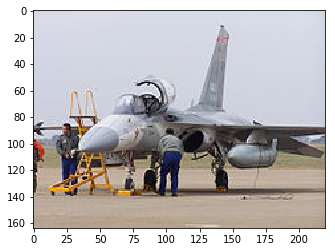

In [10]:
img = plt.imread(f'{PATH}valid/fighter-jets/{files[0]}')
plt.imshow(img);

Here is how the raw data looks like

In [11]:
img.shape

(164, 220, 3)

In [12]:
img[:4,:4]

array([[[215, 214, 228],
        [215, 214, 228],
        [215, 214, 228],
        [215, 214, 228]],

       [[215, 214, 228],
        [215, 214, 228],
        [215, 214, 228],
        [215, 214, 228]],

       [[215, 214, 228],
        [215, 214, 228],
        [216, 215, 229],
        [216, 215, 229]],

       [[216, 215, 229],
        [216, 215, 229],
        [216, 215, 229],
        [217, 216, 230]]], dtype=uint8)

## Our first model: quick start

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks). We'll be studying them in depth later, but for now we'll focus on using them effectively.

Here's how to train and evalulate a *dogs vs cats* model in 3 lines of code, and under 20 seconds:

In [13]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [14]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 6)

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                
    0      0.902702   0.588796   0.75      
    1      0.669851   0.421124   0.9             
    2      0.519636   0.316194   0.9             
    3      0.400021   0.264819   0.925           
    4      0.32604    0.246713   0.925           
    5      0.272852   0.249318   0.925           



[array([ 0.24932]), 0.92500001192092896]

## Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5).

In [15]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [16]:
# from here we know that 'airliners' is label 0 and 'fighter-jets' is label 1.
data.classes

['airliners', 'fighter-jets']

In [17]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(40, 2)

In [18]:
log_preds[:10]

array([[-0.04136, -3.20614],
       [-0.20967, -1.66524],
       [-0.00332, -5.70891],
       [-0.04441, -3.13645],
       [-0.08319, -2.52798],
       [-0.06052, -2.83487],
       [-0.06307, -2.79489],
       [-0.01085, -4.52925],
       [-0.01253, -4.38618],
       [-0.00202, -6.20601]], dtype=float32)

In [19]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [20]:
def rand_by_mask(mask):
    mask_idxs = np.where(mask)[0]
    cnt = min(4, len(mask_idxs))
    return np.random.choice(mask_idxs, cnt, replace=False)

def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified


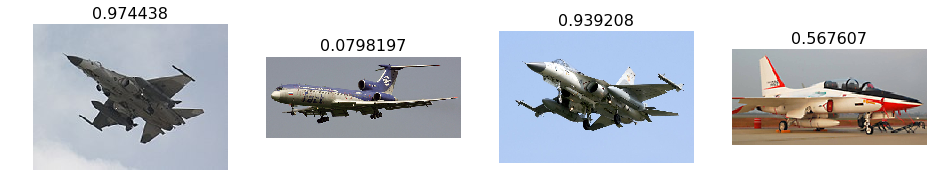

In [21]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

# 0: airliners
# 1: fighter-jets

Incorrectly classified


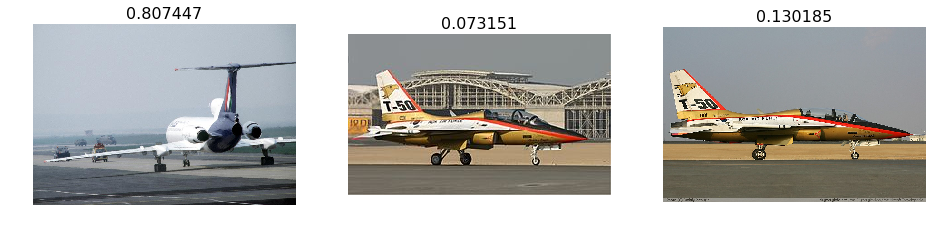

In [22]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

# If you get a ValueError in this cell,
# see this post: https://forums.fast.ai/t/how-to-use-your-own-dataset-for-lesson-1/14195/2

In [23]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct airliners


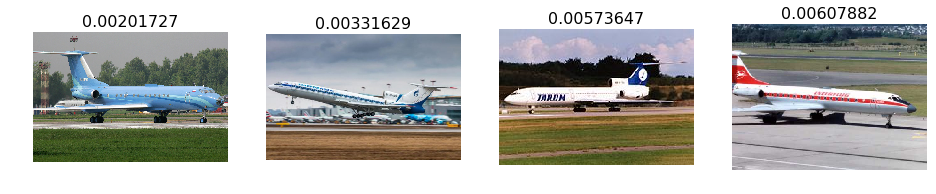

In [24]:
plot_val_with_title(most_by_correct(0, True), "Most correct airliners")

Most correct fighter-jets


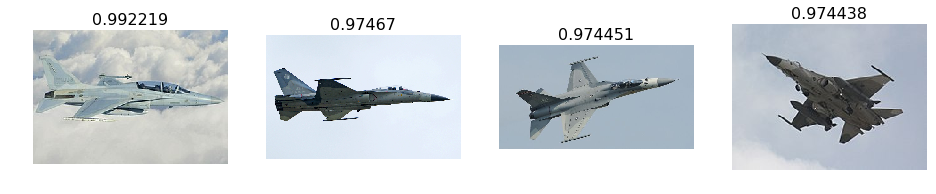

In [25]:
plot_val_with_title(most_by_correct(1, True), "Most correct fighter-jets")

Most incorrect fighter-jets


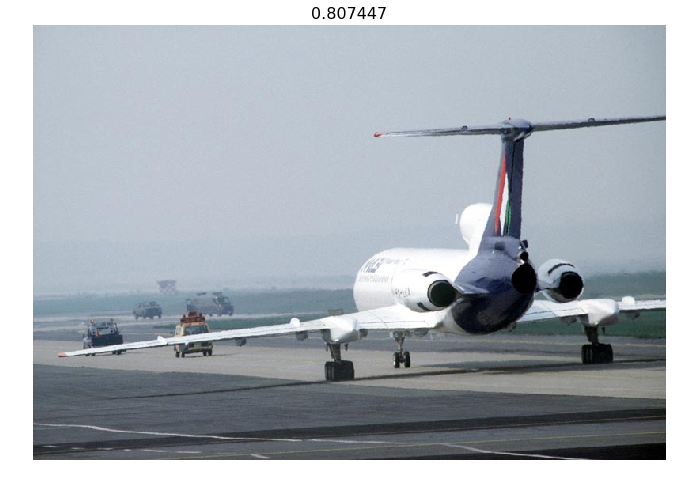

In [26]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect fighter-jets")

Most incorrect airliners


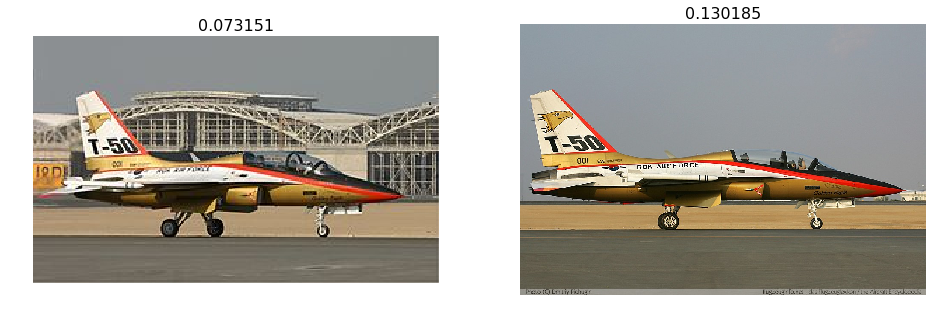

In [27]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect airliners")

Most uncertain predictions


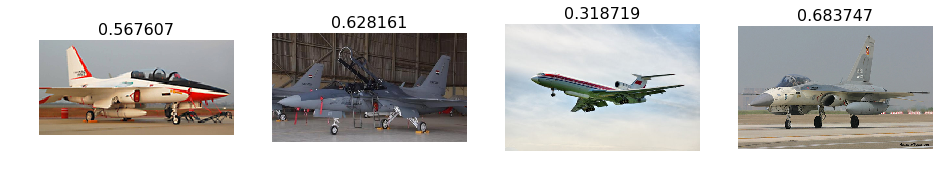

In [28]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")